# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

We want to take an N-body simulation (currently MDPL but could be anything) and put galaxies in it in a way that creates a universe consistent with HSC observations. We are building an HSC mock catalog.

To do this we use the functional form which relates stellar mass to halo mass from [Behroozi2010](https://arxiv.org/pdf/1001.0015.pdf). As this is a mean relation we will also need a scatter term which we allow to vary linearly with log(halo mass). Finally, we get a good starting fit for the Behroozi functional form from [Leauthaud2012](https://arxiv.org/pdf/1104.0928.pdf) and for the scatter term from CB in prep.

As this functional form relates stellar mass - halo mass we initially generated stellar masses using various halo masses (Mvir, Mpeak). We were able to fit the SMF but clustering was low. After talking to Peter, this is apparently known and we should instead be populating stellar mass using Vmax@Mpeak. See [appendix A](./appendix.ipynb) for a description of how we get the initial coordinates.

With these initial fits we run an optimizer that takes into account both the SM and the clustering. We find that we can match the SMF well (all bins within the error bars) but have low clustering (HSC is 18.5 +/- 1.7, mock is 14 +/- 0.2). I don't really know how to evaluate whether this is good enough.

### How to run this

* If you want to re-run the opimizer, just run everything though  (takes O(hours)).
* If you just want to build the best fit model, run everything except the optimizer (takes O(1 minute)).

## Import etc...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize
import emcee

import data as d
import likelihood as l
import plots as p
import clustering as c

import smhm_fit
from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf

%run ~/.jupyter/config.ipy

# Load data + initial config

In [2]:
# For the clustering, we look around objects with mass greater than this and
# count objects in the 0.1 dex smaller than it.
cen_sat_div = [11.65, 11.75, 11.85]

# [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]
# ^ Were the results from the very long run with ... some config (I don't really remember...)
# But I now needed to restart to get memory.

# See the appendix A for how we got these starting params
b_params = [2.4, 10.91, 0.6, 0.2, 0.2]
s_params = [-0.1, 0.5]
params = b_params + s_params
x_field = "Vmax@Mpeak"

# To speed things up we store a previous best_fit
best_fit = params = [ 2.37120547, 10.92851565,  0.34209756,  0.21683624,  0.25941454, -0.10938057,  0.51421793]

In [3]:
# The simulation data
sim_data, sim_size = d.load_mdpl()
print(np.log10(np.min(sim_data["halo_mvir"])))

# The observational data that we fit to
hsc_gals = d.load_hsc_gals()
obs_clust = np.array(
    [c.compute_hsc_clustering(hsc_gals, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
obs_smf = d.load_smf()

11.169422622696432
[Memory]67.5s, 1.1min   : Loading compute_hsc_clustering...
[Memory]67.5s, 1.1min   : Loading compute_hsc_clustering...
[Memory]67.5s, 1.1min   : Loading compute_hsc_clustering...


/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/joblib/hashing.py:212: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  self._getbuffer(obj_c_contiguous.view(self.np.uint8)))


# Find bestfit to SMF with optimizer

In [4]:
res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 1),
    method="Nelder-Mead",
    tol=0.1,
)
assert res.success == True
best_fit = res.x

[ 2.37120547 10.92851565  0.34209756  0.21683624  0.25941454 -0.10938057  0.51421793]
This is not good [267] [287]
5.572806177934076
[ 2.48976574 10.92851565  0.34209756  0.21683624  0.25941454 -0.10938057  0.51421793]
This is not good [779] [858]
This is not good [110] [181]
This is not good [16] [32]
This is not good [30] [32]
268.77985832256763
[ 2.37120547 11.47494143  0.34209756  0.21683624  0.25941454 -0.10938057  0.51421793]
1121929.5873664145
[ 2.37120547 10.92851565  0.35920244  0.21683624  0.25941454 -0.10938057  0.51421793]
This is not good [236] [280]
3.850473405465909
[ 2.37120547 10.92851565  0.34209756  0.22767805  0.25941454 -0.10938057  0.51421793]
This is not good [240] [245]
4.822120485299175
[ 2.37120547 10.92851565  0.34209756  0.21683624  0.27238527 -0.10938057  0.51421793]
4.467667513037549
[ 2.37120547 10.92851565  0.34209756  0.21683624  0.25941454 -0.1148496   0.51421793]
This is not good [162] [211]
13.250816938437644
[ 2.37120547 10.92851565  0.34209756  0.2

2.665277318704881
[ 2.38146241 10.9208278   0.35304508  0.19167772  0.27400535 -0.11042149  0.518368  ]
This is not good [242] [290]
1.6766008692917074
[ 2.38572068 10.91764458  0.35689495  0.17939674  0.27728991 -0.11074102  0.51995424]
This is not good [225] [298]
2.6195743748729603
[ 2.3818678  10.92007787  0.35407594  0.18744861  0.28015048 -0.11040094  0.5190037 ]
This is not good [214] [281]
1.9339733155933443
[ 2.37933825 10.92160989  0.35365896  0.19993682  0.27001275 -0.11054745  0.51666092]
This is not good [199] [242]
3.559967786542651
[ 2.37842659 10.92323339  0.3496525   0.19881548  0.27417656 -0.11008347  0.51768602]
This is not good [276] [295]
1.9110669344389901
[ 2.3807955  10.92021157  0.36020435  0.18450518  0.27943761 -0.10970132  0.51903887]
This is not good [261] [309]
2.003733244031841
[ 2.37998872 10.92120074  0.34926503  0.19169526  0.28037037 -0.10886363  0.51702161]
This is not good [270] [306]
2.4774297697136896
[ 2.37888353 10.92252453  0.35411996  0.197287

This is not good [294] [331]
1.7303290228710835
[ 2.38001567 10.92039659  0.35594793  0.1861945   0.27872506 -0.11086682  0.51961786]
This is not good [281] [305]
1.5504285966399183
[ 2.37983369 10.92058054  0.35548167  0.18712391  0.27831821 -0.11086292  0.51952095]
This is not good [262] [317]
1.802309456260839
[ 2.38028927 10.92020534  0.35590903  0.18580144  0.27885573 -0.11089371  0.51979497]
This is not good [253] [279]
2.1823271067920427
[ 2.38000582 10.92039907  0.35615929  0.18591784  0.27875861 -0.11088108  0.51966444]
This is not good [277] [280]
1.6952077116654278
[ 2.37995037 10.92041671  0.35580217  0.18632416  0.27865709 -0.11087948  0.51961378]
This is not good [254] [301]
1.5813847198138147
[ 2.37963026 10.92064841  0.35598533  0.18666987  0.27851075 -0.11086882  0.51942649]
This is not good [247] [346]
1.429283462147994
[ 2.37987192 10.92055307  0.35592385  0.18660702  0.27831785 -0.11087203  0.5194875 ]
This is not good [249] [305]
1.700783561500168
[ 2.38000402 10.9

This is not good [255] [302]
2.105502497295429
[ 2.37997345 10.92043085  0.35622903  0.18584127  0.27876172 -0.11090291  0.51954195]
This is not good [254] [311]
1.7459863758199514
[ 2.37997888 10.9204289   0.35622683  0.18584433  0.2787552  -0.11090276  0.51954514]
This is not good [250] [294]
2.0856812124712447
[ 2.37998082 10.92042804  0.35621498  0.18585379  0.27875549 -0.11090256  0.51954461]
This is not good [242] [298]
1.7285431410925831
[ 2.3799855  10.92042312  0.35623374  0.18581997  0.2787677  -0.11090314  0.51954836]
This is not good [232] [302]
1.9149737994160931
[ 2.3799838  10.92042284  0.35622357  0.18583256  0.27876739 -0.11090281  0.51955029]
This is not good [237] [314]
2.2568126465509595
[ 2.37998351 10.92042461  0.35622828  0.18582805  0.2787638  -0.11090369  0.51954696]
This is not good [247] [320]
1.9237524796352958
[ 2.37998197 10.92042456  0.35623039  0.18583229  0.27876228 -0.11090343  0.51954716]
This is not good [256] [308]
1.586375365710345
[ 2.37997878 10.

This is not good [238] [317]
1.953391751073728
[ 2.37998459 10.92042325  0.3562368   0.18581763  0.27877059 -0.11090355  0.51954804]
This is not good [267] [330]
1.6619470794521836
[ 2.37998462 10.92042316  0.35623726  0.18581702  0.27877079 -0.11090356  0.51954814]
This is not good [265] [291]
1.4835879270869299
[ 2.37998477 10.9204231   0.35623731  0.18581679  0.2787709  -0.11090357  0.51954815]
This is not good [243] [269]
2.2890441559875385
[ 2.37998458 10.92042323  0.35623701  0.1858173   0.27877072 -0.11090355  0.51954807]
This is not good [252] [291]
1.5458320747529553
[ 2.37998469 10.92042316  0.35623715  0.18581706  0.27877072 -0.11090356  0.51954813]
This is not good [272] [325]
1.3817887769824848
[ 2.37998466 10.92042322  0.35623666  0.18581787  0.27877042 -0.11090353  0.51954813]
This is not good [248] [306]
2.0220694890010833
[ 2.37998465 10.92042317  0.35623726  0.18581688  0.27877087 -0.11090356  0.51954809]
This is not good [251] [290]
2.2803716787638244
[ 2.37998478 10

This is not good [241] [320]
1.5323898509358553
[ 2.37998487 10.92042304  0.35623719  0.18581667  0.27877096 -0.11090356  0.51954824]
This is not good [220] [308]
2.0773682328554597
[ 2.37998487 10.92042303  0.35623718  0.18581667  0.27877096 -0.11090356  0.51954824]
This is not good [273] [277]
1.6486627912368996
[ 2.37998488 10.92042303  0.35623719  0.18581665  0.27877097 -0.11090356  0.51954824]
This is not good [236] [335]
1.910306248873793
[ 2.37998488 10.92042303  0.35623719  0.18581665  0.27877097 -0.11090357  0.51954824]
This is not good [255] [285]
1.8030501555795682
[ 2.37998487 10.92042304  0.35623718  0.18581667  0.27877096 -0.11090356  0.51954824]
This is not good [273] [299]
1.720393692406204
[ 2.37998488 10.92042303  0.35623718  0.18581665  0.27877096 -0.11090356  0.51954824]
This is not good [255] [333]
1.1711267103591463
[ 2.37998487 10.92042303  0.35623718  0.18581667  0.27877095 -0.11090356  0.51954824]
This is not good [252] [291]
1.851501101795508
[ 2.37998488 10.9

This is not good [270] [276]
2.1189834490527426
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [261] [286]
1.9305953149046777
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [254] [282]
2.2113565261681085
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [222] [315]
1.3927241343643284
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [237] [294]
1.8028790801160872
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [221] [265]
1.9198425945007183
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [272] [313]
2.129741115654314
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [241] [315]
2.0113419616457
[ 2.37998488 10.92

This is not good [243] [291]
1.7890933584128503
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [239] [301]
1.6533222692423835
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [263] [311]
1.6550970660136946
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [248] [310]
1.6479329505840543
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [251] [313]
2.097149657358952
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [243] [296]
1.8989385709689128
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [211] [318]
1.7206382699243243
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [224] [284]
1.9986176668190923
[ 2.37998488 10

This is not good [266] [312]
1.7221970982629748
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [246] [292]
1.949903840427202
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [266] [295]
1.7817518675356618
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [239] [286]
1.5635495876484176
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [223] [270]
1.6853964905681509
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [242] [285]
1.5555683991809488
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [267] [284]
2.1381685887308004
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [264] [295]
1.4443145211807735
[ 2.37998488 10

This is not good [232] [282]
2.0348795780018856
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [264] [311]
2.261026181981972
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [240] [323]
1.3653468514651863
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [252] [297]
2.0480325175931373
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [238] [299]
2.1278947298269326
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [252] [298]
1.5207248407556413
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [222] [286]
1.9879604233061152
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
1.9585151500703797
[ 2.37998488 10.92042303  0.35623719  0.1858

This is not good [254] [301]
1.623038243838157
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [260] [307]
1.53736807700887
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [256] [283]
1.8259818888489985
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [261] [298]
1.9982671639449716
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [265] [299]
1.5690386812918569
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [249] [281]
1.878432142062549
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [250] [292]
1.5168103556611325
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [246] [324]
1.7957635636047524
[ 2.37998488 10.92

This is not good [258] [295]
2.189977443542366
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [266] [293]
1.956358302807089
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [265] [297]
1.9641287448226086
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [241] [286]
1.8583076747515292
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [256] [301]
2.107097400952993
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [270] [296]
1.795690433396095
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [275] [282]
2.3820319476422287
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [224] [297]
1.8202632045666414
[ 2.37998488 10.92

This is not good [275] [310]
1.5274250114785743
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [230] [327]
1.6784832416717046
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [241] [270]
2.1920163783090745
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [261] [294]
1.8328355357034143
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [269] [338]
1.9699639772319364
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [231] [295]
2.214155811876653
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [234] [296]
1.5843661704951082
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [247] [275]
2.033546147625909
[ 2.37998488 10.

This is not good [241] [309]
1.7895952949549696
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [236] [260]
2.2593366018227288
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [274] [281]
1.9164681001849149
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [218] [278]
2.1269873679314717
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [229] [264]
2.4542361974282736
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [242] [326]
1.5996046349865558
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [256] [320]
1.7686811578989836
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [255] [286]
1.7533796851619758
[ 2.37998488 1

This is not good [239] [304]
1.7887912785689255
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [263] [292]
1.4586565267164404
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [250] [280]
1.864355715947648
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [236] [306]
1.8079009163804902
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [263] [288]
1.552755069959495
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [261] [315]
1.3881979502684543
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [242] [279]
1.9496658522151789
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [242] [311]
1.6140453436876019
[ 2.37998488 10.

This is not good [214] [307]
1.8600425442093125
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [240] [292]
2.2882533951343174
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [247] [286]
1.5654204051261882
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [250] [294]
2.2392605938862613
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [252] [273]
2.131065918067076
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [250] [319]
1.6949468803428138
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [270] [334]
1.483597690949932
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [262] [304]
1.8805691414117582
[ 2.37998488 10.

This is not good [229] [285]
1.5869389243453467
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [256] [308]
1.4182601620827264
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [241] [322]
1.4165160151067742
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [264] [314]
1.8649020130218368
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [267] [301]
1.9083967709629812
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [251] [298]
1.5330455695180774
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [233] [270]
2.190359978033323
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [243] [288]
1.8756636540430263
[ 2.37998488 10

This is not good [245] [307]
1.6299362048990556
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [254] [294]
1.268756254370529
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [261] [313]
1.3118408298958992
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [254] [293]
1.5921579619031108
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [255] [318]
1.684581787381921
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [250] [283]
1.945094184830653
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [261] [291]
1.6798731836516656
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [245] [322]
1.1858736208280767
[ 2.37998488 10.9

1.614674903546054
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [253] [299]
1.570819539330484
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [227] [291]
1.859177054460246
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [263] [318]
1.8769357828243094
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [252] [289]
1.938820059344667
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [255] [298]
2.002195283352338
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [253] [290]
2.099712480463759
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [243] [285]
1.9163820042112305
[ 2.37998488 10.92042303  0.35623719  0.18581664 

This is not good [263] [311]
2.495147315116128
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [275] [290]
1.8826556849481277
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [227] [275]
1.6369076465537529
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [266] [307]
1.754455168231474
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [242] [258]
2.1277510269877453
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [220] [281]
2.0937985883584975
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [1528] [1533]
This is not good [240] [312]
1.861535775272875
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [264] [288]
2.050

1.9353013169164528
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [265] [315]
1.4982123783700585
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [252] [273]
1.857549747989943
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [246] [303]
1.5307029343421104
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [266] [285]
1.72994375929601
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [262] [287]
1.5587475322742006
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [262] [278]
1.8242892590979702
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [267] [310]
1.3181440658612507
[ 2.37998488 10.92042303  0.35623719  0.185816

This is not good [229] [278]
2.06219501823578
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [249] [284]
1.8780773265343944
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [247] [323]
1.927168717640422
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [260] [297]
1.49521082839799
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [277] [298]
1.5235501564837355
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [259] [330]
1.3751538625731787
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [268] [308]
2.0043329508604835
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [251] [301]
1.114135823212944
[ 2.37998488 10.9204

This is not good [259] [263]
1.9935555588194578
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [254] [295]
2.0001680833418636
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [229] [264]
2.30210847566845
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [264] [308]
1.7356615668447304
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [274] [309]
1.4377073733219783
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [266] [307]
1.753454231089057
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [251] [277]
2.0297197508867164
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824]
This is not good [257] [277]
1.9799320987642348
[ 2.37998488 10.9

AssertionError: 

# Build bestfit model and compare to observations

In [8]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit[:5], best_fit[5:], x_field)

This is not good [263] [307]


[Text(0, 0.5, 'Clustering'), Text(0.5, 0, 'Sample dividing mass')]

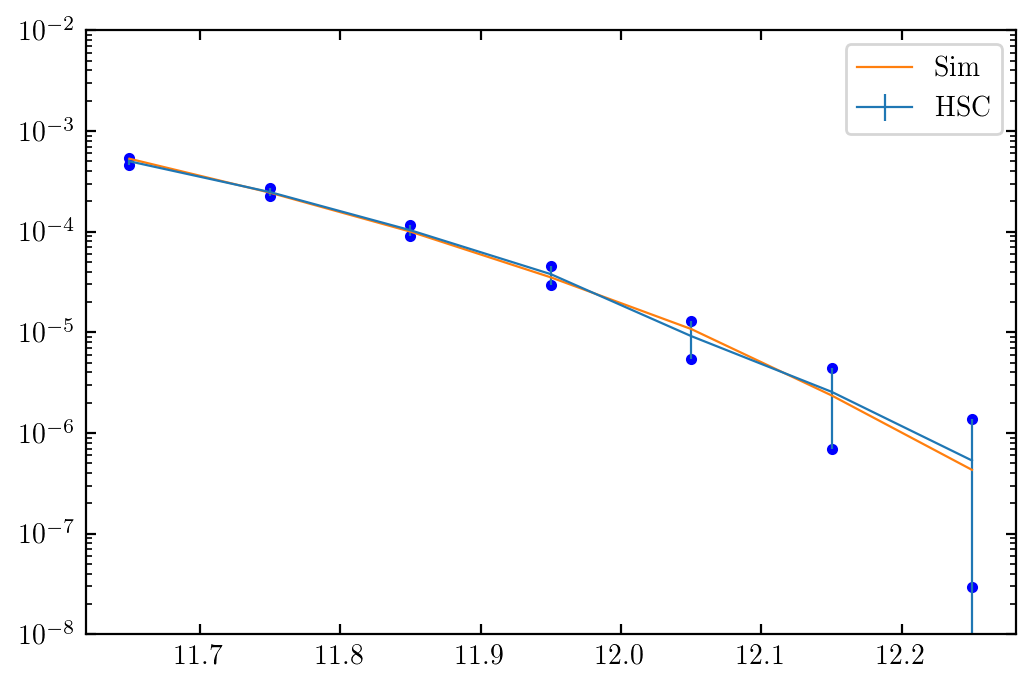

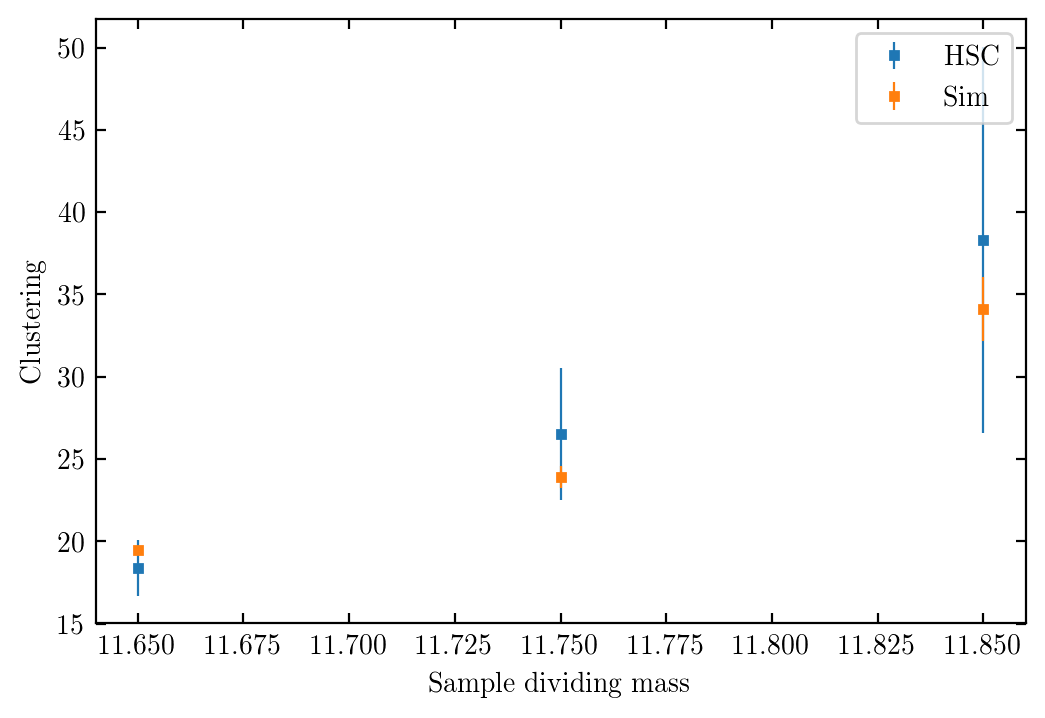

In [8]:
ax = p.plot_smfs(sim_data, obs_smf, best_fit[:5], best_fit[5:], sim_size, x_field)
ax.set(ylim=(1e-8, 1e-2));

sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])

_, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")

# Save out mock

In [9]:
sim_data_out = np.lib.recfunctions.append_fields(sim_data, names="stellar_mass", dtypes=np.float64, data=np.power(10, log_stellar_masses))
sim_data_out = np.lib.recfunctions.rename_fields(sim_data_out, {"halo_mvir": "Mpeak"})
np.save("mocks/new", np.ma.getdata(sim_data_out))

# From meeting

In [18]:
sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])

_, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")

IndexError: index 0 is out of bounds for axis 0 with size 0